# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

In [1]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator

In [124]:
image_size = 128
channels = 3

# Autoencoder.
dropout = 0.1
autoencoder_batch_size = 512
diffusion_batch_size = 2048
autoencoder_widths = [16, 8, 8]
latent_size = int(image_size / 2**len(autoencoder_widths))

# Diffusion.
min_signal_rate = 0.02
max_signal_rate = 0.95
embedding_dims = 32
embedding_max_frequency = 1000.0
diffusion_widths = [32, 64, 96]
diffusion_block_depth = 2

In [125]:
def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
dogs = idg.flow_from_directory(
    '../stanford_dogs/images/Images/', 
    target_size = (image_size, image_size), 
    batch_size = autoencoder_batch_size,
    color_mode = 'rgb',
    classes = ['']
)

Found 20580 images belonging to 1 classes.


## Variational Autoencoder

In [126]:
def EncoderBlock(widths):
    def apply(x):
        for i in range(len(widths)):
            x = layers.Conv2D(widths[i], (3, 3), activation='relu', padding='same')(x)
            x = layers.MaxPooling2D((2, 2), padding='same')(x)
        return x
    
    return apply

def DecoderBlock(widths):
    def apply(x):
        for i in range(len(widths)):
            x = layers.Conv2D(widths[i], (3, 3), activation='relu', padding='same')(x)
            x = layers.UpSampling2D((2, 2))(x)
            
        x = layers.Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
        return x
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(z_mean.shape[1], z_mean.shape[2], channels))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [127]:
class VAE(keras.Model):
    def __init__(self, widths, encoder=None, decoder=None):
        super().__init__()
        self.encoder_widths = widths
        self.decoder_widths = list(reversed(widths))
        
        if encoder != None:
            self.encoder = encoder
        else:
            self.encoder = self.create_encoder()
            
        if decoder != None:
            self.decoder = decoder
        else:
            self.decoder = self.create_decoder()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock(self.encoder_widths)(input_image)
        z_mean = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(latent_size, latent_size, channels))
        decoded = DecoderBlock(self.decoder_widths)(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data)
        return z
    
    def decode(self, data):
        x = self.decoder(data)
        return x

In [128]:
vae = VAE(autoencoder_widths)
vae.compile(optimizer='adam')

In [162]:
vae.fit(dogs, epochs=1000)

Epoch 1/1000
41/41 [==============================] - 18s 430ms/step - loss: 9085.6242 - reconstruction_loss: 9061.1475 - kl_loss: 42.6710
Epoch 2/1000
41/41 [==============================] - 19s 449ms/step - loss: 9108.0503 - reconstruction_loss: 9061.1084 - kl_loss: 42.7537
Epoch 3/1000
41/41 [==============================] - 18s 456ms/step - loss: 9111.7181 - reconstruction_loss: 9065.0029 - kl_loss: 42.8817
Epoch 4/1000
41/41 [==============================] - 18s 440ms/step - loss: 9103.3518 - reconstruction_loss: 9061.0264 - kl_loss: 42.8027
Epoch 5/1000
41/41 [==============================] - 18s 448ms/step - loss: 9111.2706 - reconstruction_loss: 9061.4639 - kl_loss: 42.6483
Epoch 6/1000
41/41 [==============================] - 18s 448ms/step - loss: 9108.5879 - reconstruction_loss: 9061.4746 - kl_loss: 42.9725
Epoch 7/1000
41/41 [==============================] - 18s 442ms/step - loss: 9101.7352 - reconstruction_loss: 9060.9736 - kl_loss: 42.7128
Epoch 8/1000
41/41 [=======

41/41 [==============================] - 18s 429ms/step - loss: 9095.2887 - reconstruction_loss: 9040.7676 - kl_loss: 42.1143
Epoch 60/1000
41/41 [==============================] - 18s 434ms/step - loss: 9088.2058 - reconstruction_loss: 9040.1963 - kl_loss: 42.2300
Epoch 61/1000
41/41 [==============================] - 18s 433ms/step - loss: 9077.5582 - reconstruction_loss: 9040.3467 - kl_loss: 42.0559
Epoch 62/1000
41/41 [==============================] - 18s 432ms/step - loss: 9071.3267 - reconstruction_loss: 9032.9824 - kl_loss: 42.0287
Epoch 63/1000
41/41 [==============================] - 18s 430ms/step - loss: 9072.7288 - reconstruction_loss: 9033.1582 - kl_loss: 42.1802
Epoch 64/1000
41/41 [==============================] - 18s 428ms/step - loss: 9081.3305 - reconstruction_loss: 9036.3174 - kl_loss: 42.1600
Epoch 65/1000
41/41 [==============================] - 18s 431ms/step - loss: 9070.8672 - reconstruction_loss: 9035.2168 - kl_loss: 42.1822
Epoch 66/1000
41/41 [=============

41/41 [==============================] - 18s 429ms/step - loss: 9071.1396 - reconstruction_loss: 9025.4258 - kl_loss: 41.0681
Epoch 118/1000
41/41 [==============================] - 18s 431ms/step - loss: 9060.7785 - reconstruction_loss: 9026.6982 - kl_loss: 41.1096
Epoch 119/1000
41/41 [==============================] - 18s 428ms/step - loss: 9078.9030 - reconstruction_loss: 9024.5977 - kl_loss: 40.8439
Epoch 120/1000
41/41 [==============================] - 18s 430ms/step - loss: 9068.2856 - reconstruction_loss: 9026.6543 - kl_loss: 40.8248
Epoch 121/1000
41/41 [==============================] - 18s 426ms/step - loss: 9052.3605 - reconstruction_loss: 9023.4062 - kl_loss: 41.0293
Epoch 122/1000
41/41 [==============================] - 18s 427ms/step - loss: 9074.1003 - reconstruction_loss: 9023.8145 - kl_loss: 40.8972
Epoch 123/1000
41/41 [==============================] - 18s 432ms/step - loss: 9063.1876 - reconstruction_loss: 9022.5986 - kl_loss: 40.9278
Epoch 124/1000
41/41 [======

41/41 [==============================] - 18s 427ms/step - loss: 9071.7878 - reconstruction_loss: 9022.9590 - kl_loss: 39.9738
Epoch 176/1000
41/41 [==============================] - 18s 430ms/step - loss: 9051.5292 - reconstruction_loss: 9017.0146 - kl_loss: 39.9171
Epoch 177/1000
41/41 [==============================] - 18s 427ms/step - loss: 9049.8521 - reconstruction_loss: 9017.3994 - kl_loss: 39.9051
Epoch 178/1000
41/41 [==============================] - 18s 429ms/step - loss: 9072.8931 - reconstruction_loss: 9014.9639 - kl_loss: 39.9598
Epoch 179/1000
41/41 [==============================] - 18s 429ms/step - loss: 9057.0161 - reconstruction_loss: 9020.3457 - kl_loss: 39.8471
Epoch 180/1000
41/41 [==============================] - 18s 430ms/step - loss: 9073.8510 - reconstruction_loss: 9018.1621 - kl_loss: 40.0501
Epoch 181/1000
41/41 [==============================] - 18s 424ms/step - loss: 9059.5655 - reconstruction_loss: 9019.3887 - kl_loss: 39.7970
Epoch 182/1000
41/41 [======

41/41 [==============================] - 18s 440ms/step - loss: 9043.5586 - reconstruction_loss: 9015.7217 - kl_loss: 38.9641
Epoch 234/1000
41/41 [==============================] - 18s 444ms/step - loss: 9041.5980 - reconstruction_loss: 9006.5674 - kl_loss: 38.9677
Epoch 235/1000
41/41 [==============================] - 18s 447ms/step - loss: 9043.1386 - reconstruction_loss: 9011.7588 - kl_loss: 38.8401
Epoch 236/1000
41/41 [==============================] - 18s 447ms/step - loss: 9049.7384 - reconstruction_loss: 9012.2969 - kl_loss: 38.8356
Epoch 237/1000
41/41 [==============================] - 18s 445ms/step - loss: 9055.3154 - reconstruction_loss: 9010.5771 - kl_loss: 38.9567
Epoch 238/1000
41/41 [==============================] - 18s 441ms/step - loss: 9047.9508 - reconstruction_loss: 9018.5000 - kl_loss: 38.9187
Epoch 239/1000
41/41 [==============================] - 18s 444ms/step - loss: 9056.8514 - reconstruction_loss: 9013.8857 - kl_loss: 39.0041
Epoch 240/1000
41/41 [======

41/41 [==============================] - 18s 426ms/step - loss: 9035.3863 - reconstruction_loss: 9007.7617 - kl_loss: 38.2000
Epoch 292/1000
41/41 [==============================] - 18s 428ms/step - loss: 9048.8269 - reconstruction_loss: 9009.0234 - kl_loss: 38.2534
Epoch 293/1000
41/41 [==============================] - 18s 427ms/step - loss: 9047.3003 - reconstruction_loss: 9013.9756 - kl_loss: 38.1961
Epoch 294/1000
41/41 [==============================] - 17s 423ms/step - loss: 9040.3839 - reconstruction_loss: 9012.9219 - kl_loss: 38.1844
Epoch 295/1000
41/41 [==============================] - 18s 428ms/step - loss: 9034.8849 - reconstruction_loss: 9007.0713 - kl_loss: 38.3266
Epoch 296/1000
41/41 [==============================] - 18s 429ms/step - loss: 9046.4764 - reconstruction_loss: 9012.3877 - kl_loss: 38.1066
Epoch 297/1000
41/41 [==============================] - 18s 429ms/step - loss: 9053.5955 - reconstruction_loss: 9009.4424 - kl_loss: 38.3276
Epoch 298/1000
41/41 [======

41/41 [==============================] - 17s 424ms/step - loss: 9031.1115 - reconstruction_loss: 9003.7930 - kl_loss: 37.6283
Epoch 350/1000
41/41 [==============================] - 18s 430ms/step - loss: 9049.8737 - reconstruction_loss: 9003.1611 - kl_loss: 37.8379
Epoch 351/1000
41/41 [==============================] - 18s 428ms/step - loss: 9037.8330 - reconstruction_loss: 9005.6562 - kl_loss: 37.9053
Epoch 352/1000
41/41 [==============================] - 18s 428ms/step - loss: 9037.5458 - reconstruction_loss: 9001.5479 - kl_loss: 38.0262
Epoch 353/1000
41/41 [==============================] - 18s 432ms/step - loss: 9043.8288 - reconstruction_loss: 9008.4209 - kl_loss: 37.7418
Epoch 354/1000
41/41 [==============================] - 18s 432ms/step - loss: 9075.9067 - reconstruction_loss: 9012.7695 - kl_loss: 37.9085
Epoch 355/1000
41/41 [==============================] - 18s 432ms/step - loss: 9041.9702 - reconstruction_loss: 9008.8418 - kl_loss: 37.7919
Epoch 356/1000
41/41 [======

41/41 [==============================] - 18s 435ms/step - loss: 9048.5722 - reconstruction_loss: 9008.0400 - kl_loss: 37.6353
Epoch 408/1000
41/41 [==============================] - 18s 437ms/step - loss: 9042.7698 - reconstruction_loss: 9001.0312 - kl_loss: 37.7214
Epoch 409/1000
41/41 [==============================] - 18s 437ms/step - loss: 9022.8263 - reconstruction_loss: 9003.2451 - kl_loss: 37.7058
Epoch 410/1000
41/41 [==============================] - 18s 432ms/step - loss: 9047.1721 - reconstruction_loss: 9003.6992 - kl_loss: 37.4571
Epoch 411/1000
41/41 [==============================] - 18s 432ms/step - loss: 9040.8938 - reconstruction_loss: 9007.3955 - kl_loss: 37.5705
Epoch 412/1000
41/41 [==============================] - 18s 433ms/step - loss: 9033.1185 - reconstruction_loss: 9001.9424 - kl_loss: 37.6975
Epoch 413/1000
41/41 [==============================] - 18s 433ms/step - loss: 9032.4846 - reconstruction_loss: 9004.2656 - kl_loss: 37.5899
Epoch 414/1000
41/41 [======

41/41 [==============================] - 18s 432ms/step - loss: 9049.1974 - reconstruction_loss: 9004.5957 - kl_loss: 37.5471
Epoch 466/1000
41/41 [==============================] - 18s 431ms/step - loss: 9040.2299 - reconstruction_loss: 9000.8438 - kl_loss: 37.5716
Epoch 467/1000
41/41 [==============================] - 18s 428ms/step - loss: 9056.1441 - reconstruction_loss: 9005.4639 - kl_loss: 37.4327
Epoch 468/1000
41/41 [==============================] - 18s 431ms/step - loss: 9045.9880 - reconstruction_loss: 9001.4023 - kl_loss: 37.5154
Epoch 469/1000
41/41 [==============================] - 18s 443ms/step - loss: 9036.9511 - reconstruction_loss: 9003.0117 - kl_loss: 37.5178
Epoch 470/1000
41/41 [==============================] - 18s 434ms/step - loss: 9051.2542 - reconstruction_loss: 9005.8086 - kl_loss: 37.2670
Epoch 471/1000
41/41 [==============================] - 18s 428ms/step - loss: 9039.5299 - reconstruction_loss: 9001.2900 - kl_loss: 37.4039
Epoch 472/1000
41/41 [======

41/41 [==============================] - 18s 434ms/step - loss: 9041.8715 - reconstruction_loss: 9003.0332 - kl_loss: 37.1858
Epoch 524/1000
41/41 [==============================] - 18s 432ms/step - loss: 9038.0306 - reconstruction_loss: 8997.4990 - kl_loss: 37.4436
Epoch 525/1000
41/41 [==============================] - 18s 432ms/step - loss: 9033.8926 - reconstruction_loss: 8999.1709 - kl_loss: 37.2286
Epoch 526/1000
41/41 [==============================] - 18s 437ms/step - loss: 9035.3612 - reconstruction_loss: 8998.3506 - kl_loss: 37.2665
Epoch 527/1000
41/41 [==============================] - 18s 435ms/step - loss: 9035.3040 - reconstruction_loss: 8999.0322 - kl_loss: 37.2072
Epoch 528/1000
41/41 [==============================] - 18s 431ms/step - loss: 9035.0041 - reconstruction_loss: 9000.4668 - kl_loss: 37.3954
Epoch 529/1000
41/41 [==============================] - 18s 431ms/step - loss: 9028.9604 - reconstruction_loss: 9002.7910 - kl_loss: 37.3559
Epoch 530/1000
41/41 [======

41/41 [==============================] - 18s 430ms/step - loss: 9047.6732 - reconstruction_loss: 9002.7207 - kl_loss: 37.1473
Epoch 582/1000
41/41 [==============================] - 18s 433ms/step - loss: 9039.9636 - reconstruction_loss: 9000.0215 - kl_loss: 37.1732
Epoch 583/1000
41/41 [==============================] - 18s 437ms/step - loss: 9028.8789 - reconstruction_loss: 8998.6445 - kl_loss: 37.2734
Epoch 584/1000
41/41 [==============================] - 18s 435ms/step - loss: 9018.6135 - reconstruction_loss: 8997.7646 - kl_loss: 37.2132
Epoch 585/1000
41/41 [==============================] - 18s 432ms/step - loss: 9048.0089 - reconstruction_loss: 8997.3662 - kl_loss: 37.1952
Epoch 586/1000
41/41 [==============================] - 18s 433ms/step - loss: 9029.6826 - reconstruction_loss: 8997.6514 - kl_loss: 37.4124
Epoch 587/1000
41/41 [==============================] - 18s 444ms/step - loss: 9039.7923 - reconstruction_loss: 8998.2070 - kl_loss: 37.1648
Epoch 588/1000
41/41 [======

41/41 [==============================] - 18s 429ms/step - loss: 9032.5361 - reconstruction_loss: 9001.9990 - kl_loss: 37.1177
Epoch 640/1000
41/41 [==============================] - 18s 425ms/step - loss: 9041.6994 - reconstruction_loss: 8994.8467 - kl_loss: 37.0652
Epoch 641/1000
41/41 [==============================] - 18s 427ms/step - loss: 9040.1494 - reconstruction_loss: 8994.9297 - kl_loss: 37.0285
Epoch 642/1000
41/41 [==============================] - 18s 426ms/step - loss: 9038.6975 - reconstruction_loss: 8997.9414 - kl_loss: 36.9104
Epoch 643/1000
41/41 [==============================] - 18s 428ms/step - loss: 9027.1371 - reconstruction_loss: 8998.6475 - kl_loss: 37.2324
Epoch 644/1000
41/41 [==============================] - 18s 425ms/step - loss: 9038.8306 - reconstruction_loss: 8998.3633 - kl_loss: 36.9832
Epoch 645/1000
41/41 [==============================] - 18s 426ms/step - loss: 9029.7136 - reconstruction_loss: 9002.8281 - kl_loss: 37.1650
Epoch 646/1000
41/41 [======

41/41 [==============================] - 18s 426ms/step - loss: 9039.4133 - reconstruction_loss: 8995.9326 - kl_loss: 36.9487
Epoch 698/1000
41/41 [==============================] - 18s 427ms/step - loss: 9027.4502 - reconstruction_loss: 8998.6387 - kl_loss: 37.0542
Epoch 699/1000
41/41 [==============================] - 18s 425ms/step - loss: 9034.1661 - reconstruction_loss: 8998.0986 - kl_loss: 36.8222
Epoch 700/1000
41/41 [==============================] - 18s 429ms/step - loss: 9035.7965 - reconstruction_loss: 9001.0244 - kl_loss: 37.0932
Epoch 701/1000
41/41 [==============================] - 18s 429ms/step - loss: 9030.5867 - reconstruction_loss: 8998.5332 - kl_loss: 36.9960
Epoch 702/1000
41/41 [==============================] - 17s 423ms/step - loss: 9041.2905 - reconstruction_loss: 8997.8164 - kl_loss: 36.9636
Epoch 703/1000
41/41 [==============================] - 18s 428ms/step - loss: 9037.5145 - reconstruction_loss: 8999.2969 - kl_loss: 36.7666
Epoch 704/1000
41/41 [======

41/41 [==============================] - 18s 434ms/step - loss: 9046.8689 - reconstruction_loss: 8998.9219 - kl_loss: 36.7622
Epoch 756/1000
41/41 [==============================] - 18s 430ms/step - loss: 9025.8805 - reconstruction_loss: 8993.8047 - kl_loss: 36.8850
Epoch 757/1000
41/41 [==============================] - 18s 430ms/step - loss: 9037.7734 - reconstruction_loss: 8998.4189 - kl_loss: 36.8330
Epoch 758/1000
41/41 [==============================] - 18s 433ms/step - loss: 9033.6275 - reconstruction_loss: 8994.4707 - kl_loss: 37.0223
Epoch 759/1000
41/41 [==============================] - 18s 431ms/step - loss: 9036.8527 - reconstruction_loss: 8997.0039 - kl_loss: 36.7702
Epoch 760/1000
41/41 [==============================] - 18s 435ms/step - loss: 9026.1820 - reconstruction_loss: 8994.9268 - kl_loss: 37.1049
Epoch 761/1000
41/41 [==============================] - 18s 437ms/step - loss: 9025.1368 - reconstruction_loss: 8994.1221 - kl_loss: 36.7675
Epoch 762/1000
41/41 [======

41/41 [==============================] - 18s 427ms/step - loss: 9033.0017 - reconstruction_loss: 8991.2549 - kl_loss: 36.8789
Epoch 814/1000
41/41 [==============================] - 18s 432ms/step - loss: 9032.6643 - reconstruction_loss: 8996.6582 - kl_loss: 36.6698
Epoch 815/1000
41/41 [==============================] - 18s 426ms/step - loss: 9049.2677 - reconstruction_loss: 8997.0674 - kl_loss: 36.7546
Epoch 816/1000
41/41 [==============================] - 18s 426ms/step - loss: 9041.3797 - reconstruction_loss: 8991.6064 - kl_loss: 36.6439
Epoch 817/1000
41/41 [==============================] - 18s 428ms/step - loss: 9025.6521 - reconstruction_loss: 8996.9658 - kl_loss: 36.7863
Epoch 818/1000
41/41 [==============================] - 18s 426ms/step - loss: 9052.3949 - reconstruction_loss: 8996.6650 - kl_loss: 36.7377
Epoch 819/1000
41/41 [==============================] - 18s 427ms/step - loss: 9026.4262 - reconstruction_loss: 8994.7969 - kl_loss: 36.6015
Epoch 820/1000
41/41 [======

41/41 [==============================] - 18s 429ms/step - loss: 9031.6228 - reconstruction_loss: 8996.2139 - kl_loss: 36.5569
Epoch 872/1000
41/41 [==============================] - 18s 426ms/step - loss: 9025.4085 - reconstruction_loss: 8996.8320 - kl_loss: 36.5911
Epoch 873/1000
41/41 [==============================] - 18s 427ms/step - loss: 9036.1808 - reconstruction_loss: 8996.2285 - kl_loss: 36.7154
Epoch 874/1000
41/41 [==============================] - 18s 430ms/step - loss: 9028.1173 - reconstruction_loss: 8995.4111 - kl_loss: 36.7190
Epoch 875/1000
41/41 [==============================] - 18s 426ms/step - loss: 9032.4184 - reconstruction_loss: 8994.2227 - kl_loss: 36.6004
Epoch 876/1000
41/41 [==============================] - 18s 428ms/step - loss: 9027.6872 - reconstruction_loss: 8991.4785 - kl_loss: 36.7194
Epoch 877/1000
41/41 [==============================] - 18s 427ms/step - loss: 9036.7982 - reconstruction_loss: 8996.8281 - kl_loss: 36.4881
Epoch 878/1000
41/41 [======

41/41 [==============================] - 18s 433ms/step - loss: 9022.0993 - reconstruction_loss: 8992.3447 - kl_loss: 36.7372
Epoch 930/1000
41/41 [==============================] - 18s 431ms/step - loss: 9027.5574 - reconstruction_loss: 8997.9668 - kl_loss: 36.4541
Epoch 931/1000
41/41 [==============================] - 18s 426ms/step - loss: 9020.8717 - reconstruction_loss: 8993.9883 - kl_loss: 36.6469
Epoch 932/1000
41/41 [==============================] - 18s 431ms/step - loss: 9033.8487 - reconstruction_loss: 8993.7412 - kl_loss: 36.5677
Epoch 933/1000
41/41 [==============================] - 18s 435ms/step - loss: 9033.9321 - reconstruction_loss: 8992.4766 - kl_loss: 36.4507
Epoch 934/1000
41/41 [==============================] - 18s 430ms/step - loss: 9027.7431 - reconstruction_loss: 8995.3604 - kl_loss: 36.6748
Epoch 935/1000
41/41 [==============================] - 18s 432ms/step - loss: 9023.6726 - reconstruction_loss: 8997.9463 - kl_loss: 36.5624
Epoch 936/1000
41/41 [======

41/41 [==============================] - 18s 424ms/step - loss: 9023.6372 - reconstruction_loss: 8990.9219 - kl_loss: 36.3825
Epoch 988/1000
41/41 [==============================] - 18s 429ms/step - loss: 9029.3619 - reconstruction_loss: 8990.7158 - kl_loss: 36.3686
Epoch 989/1000
41/41 [==============================] - 17s 423ms/step - loss: 9017.1787 - reconstruction_loss: 8990.9424 - kl_loss: 36.5349
Epoch 990/1000
41/41 [==============================] - 18s 427ms/step - loss: 9032.2975 - reconstruction_loss: 8995.4004 - kl_loss: 36.3886
Epoch 991/1000
41/41 [==============================] - 17s 423ms/step - loss: 9030.5662 - reconstruction_loss: 8996.1914 - kl_loss: 36.4391
Epoch 992/1000
41/41 [==============================] - 18s 433ms/step - loss: 9020.7901 - reconstruction_loss: 8996.1924 - kl_loss: 36.4045
Epoch 993/1000
41/41 [==============================] - 18s 427ms/step - loss: 9024.6561 - reconstruction_loss: 8992.0566 - kl_loss: 36.3527
Epoch 994/1000
41/41 [======

In [163]:
vae.encoder.save('data/encoder7')
vae.decoder.save('data/decoder7')

INFO:tensorflow:Assets written to: data/encoder7\assets


INFO:tensorflow:Assets written to: data/encoder7\assets


INFO:tensorflow:Assets written to: data/decoder7\assets


INFO:tensorflow:Assets written to: data/decoder7\assets


In [164]:
dogs.reset()
encoded_images = vae.encode(dogs.next()[0])

for i in range(dogs.__len__()):
    next_encoded = vae.encode(dogs.next()[0])
    encoded_images = tf.concat([encoded_images, next_encoded], axis=0)

encoded_images.shape

TensorShape([21092, 16, 16, 3])

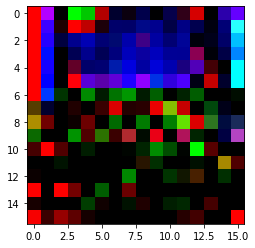

In [175]:
plt.imshow(encoded_images[0].numpy().reshape(latent_size, latent_size, channels))

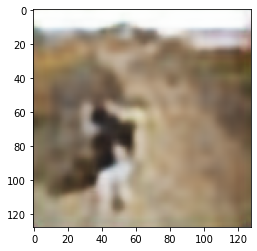

In [176]:
decoded_images = vae.decode(encoded_images[0 : 2])
plt.imshow(decoded_images[1].numpy().reshape(image_size, image_size, channels))

## Denoising U-Net

In [167]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [168]:
class DiffusionModel(keras.Model):
    def __init__(self, input_size, block_depth, widths):
        super().__init__()
        
        self.normalizer = layers.Normalization()
        self.model = self.create_model(input_size, widths, block_depth)
        self.input_size = input_size
    
    def create_model(self, input_size, widths, block_depth):
        noisy_input = keras.Input(shape=(input_size, input_size, channels))
        noise_variances = keras.Input(shape=(1, 1, 1))
        
        e = layers.Lambda(sinusoidal_embedding)(noise_variances)
        e = layers.UpSampling2D(size=input_size, interpolation='nearest')(e)
        
        x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
        x = layers.Concatenate()([x, e])
        
        skips = []
        for width in widths[:-1]:
            x = DownBlock(width, block_depth)([x, skips])
            
        for _ in range(block_depth):
            x = ResidualBlock(widths[-1])(x)
        
        for width in reversed(widths[:-1]):
            x = UpBlock(width, block_depth)([x, skips])
            
        x = layers.Conv2D(channels, kernel_size=1, kernel_initializer='zeros')(x)
        
        return keras.Model([noisy_input, noise_variances], x)
    
    def compile(self, **kwargs):
        super().compile(**kwargs)
        
        self.noise_loss_tracker = keras.metrics.Mean(name='n_loss')
        self.image_loss_tracker = keras.metrics.Mean(name='i_loss')
    
    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]
    
    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates
    
    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        pred_noises = self.model([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        return pred_noises, pred_images
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]    
        step_size = 1.0 / diffusion_steps
        
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            
        return pred_images
    
    def generate(self, num_images, diffusion_steps):
        initial_noise = tf.random.normal(shape=(num_images, self.input_size, self.input_size, channels))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        return generated_images
    
    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(diffusion_batch_size, self.input_size, self.input_size, channels))
        
        diffusion_times = tf.random.uniform(
            shape=(diffusion_batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        
        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            
            noise_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(noises, pred_noises), axis=(1, 2)
                )
            )
            
            image_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(images, pred_images), axis=(1, 2)
                )
            )
            
        grads = tape.gradient(noise_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)
            
        return {m.name: m.result() for m in self.metrics}

In [169]:
end_index = int(encoded_images.shape[0] / diffusion_batch_size) * diffusion_batch_size
encoded_images = encoded_images[:end_index]

In [170]:
model = DiffusionModel(latent_size, diffusion_block_depth, diffusion_widths)
model.compile(optimizer='adam')

In [171]:
model.fit(encoded_images, epochs=100, batch_size=diffusion_batch_size)

Epoch 1/100
10/10 [==============================] - 3s 129ms/step - n_loss: 191.3065 - i_loss: 586.7368
Epoch 2/100
10/10 [==============================] - 1s 129ms/step - n_loss: 134.1861 - i_loss: 331.4402
Epoch 3/100
10/10 [==============================] - 1s 129ms/step - n_loss: 110.6335 - i_loss: 232.2258
Epoch 4/100
10/10 [==============================] - 1s 129ms/step - n_loss: 103.8599 - i_loss: 193.4379
Epoch 5/100
10/10 [==============================] - 1s 129ms/step - n_loss: 99.3024 - i_loss: 171.2724
Epoch 6/100
10/10 [==============================] - 1s 129ms/step - n_loss: 96.6101 - i_loss: 158.7737
Epoch 7/100
10/10 [==============================] - 1s 130ms/step - n_loss: 94.7730 - i_loss: 150.7174
Epoch 8/100
10/10 [==============================] - 1s 130ms/step - n_loss: 92.8806 - i_loss: 145.0767
Epoch 9/100
10/10 [==============================] - 1s 129ms/step - n_loss: 91.6379 - i_loss: 141.7840
Epoch 10/100
10/10 [==============================] - 1s 129

10/10 [==============================] - 1s 129ms/step - n_loss: 82.5924 - i_loss: 119.7307
Epoch 80/100
10/10 [==============================] - 1s 129ms/step - n_loss: 83.1529 - i_loss: 118.9658
Epoch 81/100
10/10 [==============================] - 1s 129ms/step - n_loss: 82.6994 - i_loss: 119.9652
Epoch 82/100
10/10 [==============================] - 1s 129ms/step - n_loss: 82.8420 - i_loss: 119.6145
Epoch 83/100
10/10 [==============================] - 1s 129ms/step - n_loss: 82.4871 - i_loss: 120.4765
Epoch 84/100
10/10 [==============================] - 1s 129ms/step - n_loss: 82.2819 - i_loss: 120.1737
Epoch 85/100
10/10 [==============================] - 1s 129ms/step - n_loss: 82.7974 - i_loss: 119.4727
Epoch 86/100
10/10 [==============================] - 1s 129ms/step - n_loss: 82.6194 - i_loss: 119.1376
Epoch 87/100
10/10 [==============================] - 1s 129ms/step - n_loss: 82.8387 - i_loss: 118.6027
Epoch 88/100
10/10 [==============================] - 1s 129ms/step 

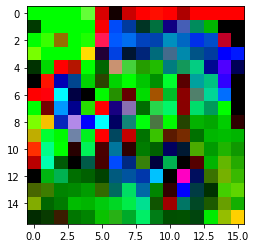

In [172]:
generated_latents = model.generate(8, 20)
plt.imshow(generated_latents[2].numpy().reshape(latent_size, latent_size, channels))

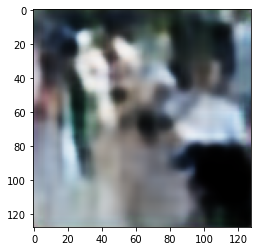

In [196]:
generated_latents = model.generate(2, 20)
generated_images = vae.decode(generated_latents)
plt.imshow(generated_images[0].numpy().reshape(image_size, image_size, channels), cmap='gray')

In [310]:
unet.save('../latent_diffusion_unet3')

INFO:tensorflow:Assets written to: ../latent_diffusion_unet3\assets


INFO:tensorflow:Assets written to: ../latent_diffusion_unet3\assets
